In [25]:
import bz2
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,precision_score ,accuracy_score
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint
import pickle

In [11]:
with open('/content/train.ft.txt', 'r', encoding='utf-8') as file:
    train_lines = file.readlines()

with open('/content/test.ft.txt', 'r', encoding='utf-8') as file:
    test_lines = file.readlines()

In [12]:
train_texts, train_labels = [], []
for line in train_lines:
    parts = line.split('__label__')
    train_labels.append(parts[1][0])
    train_texts.append(parts[1][1:])

test_texts, test_labels = [], []
for line in test_lines:
    parts = line.split('__label__')
    test_labels.append(parts[1][0])
    test_texts.append(parts[1][1:])

In [13]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

cleaned_train_texts = [clean_text(text) for text in train_texts]
cleaned_test_texts = [clean_text(text) for text in test_texts]

In [14]:
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

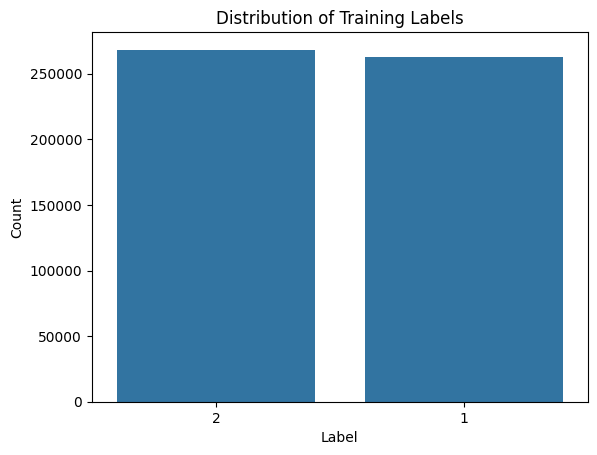

In [16]:
sns.countplot(x='label', data=train_labels_df)
plt.title('Distribution of Training Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

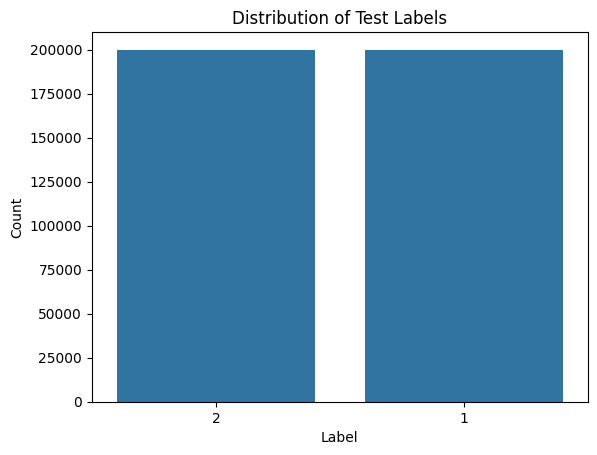

In [17]:
sns.countplot(x='label', data=test_labels_df, )
plt.title('Distribution of Test Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [18]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(cleaned_train_texts)

train_sequences = tokenizer.texts_to_sequences(cleaned_train_texts)
test_sequences = tokenizer.texts_to_sequences(cleaned_test_texts)

train_padded = pad_sequences(train_sequences, maxlen=100)
test_padded = pad_sequences(test_sequences, maxlen=100)

train_labels_binary = np.array([1 if label == '2' else 0 for label in train_labels])
test_labels_binary = np.array([1 if label == '2' else 0 for label in test_labels])

In [19]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=64, input_length=100))
model.add(LSTM(64, return_sequences=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           1280000   
                                                                 
 lstm_5 (LSTM)               (None, 100, 64)           33024     
                                                                 
 spatial_dropout1d_3 (Spati  (None, 100, 64)           0         
 alDropout1D)                                                    
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1346113 (5.14 MB)
Trainable params: 1346113 (5.14 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [20]:
history = model.fit(train_padded, train_labels_binary, epochs=5, validation_split=0.1, batch_size=64)

Epoch 1/5
7466/7466 [==============================] - 132s 17ms/step - loss: 0.2389 - accuracy: 0.9039 - val_loss: 0.1974 - val_accuracy: 0.9227
Epoch 2/5
7466/7466 [==============================] - 93s 12ms/step - loss: 0.1726 - accuracy: 0.9343 - val_loss: 0.1869 - val_accuracy: 0.9263
Epoch 3/5
7466/7466 [==============================] - 91s 12ms/step - loss: 0.1431 - accuracy: 0.9468 - val_loss: 0.1944 - val_accuracy: 0.9194
Epoch 4/5
7466/7466 [==============================] - 92s 12ms/step - loss: 0.1172 - accuracy: 0.9578 - val_loss: 0.1979 - val_accuracy: 0.9251
Epoch 5/5
7466/7466 [==============================] - 91s 12ms/step - loss: 0.0945 - accuracy: 0.9671 - val_loss: 0.2230 - val_accuracy: 0.9215


12500/12500 [==============================] - 58s 5ms/step
Accuracy:  92.184
F1 Score:  92.17092544549398
Recall:  92.01700000000001
Precision:  92.32536672486104


<Axes: >

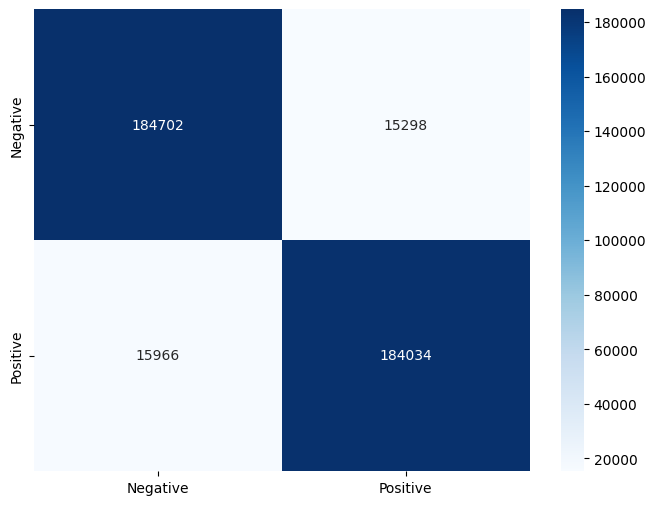

In [26]:
predictions = (model.predict(test_padded) > 0.5).astype("int32")

acc =accuracy_score(test_labels_binary, predictions)
print('Accuracy: ',acc*100)

f1 = f1_score(test_labels_binary, predictions)
print('F1 Score: ',f1*100)

recall = recall_score(test_labels_binary, predictions)
print('Recall: ',recall*100)

precision = precision_score(test_labels_binary, predictions)
print('Precision: ',precision*100)

cm = confusion_matrix(test_labels_binary, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

In [27]:
new_text = "This movie is terrible, I hated it."
new_text = clean_text(new_text)
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded = pad_sequences(new_sequence, maxlen=100)
prediction = model.predict(new_padded)
if prediction > 0.5:
  print("Positive sentiment")
else:
  print("Negative sentiment")

1/1 [==============================] - 1s 695ms/step
Negative sentiment


In [28]:
new_text = "The movie was amazing! I loved every minute of it."
new_text = clean_text(new_text)
new_sequence = tokenizer.texts_to_sequences([new_text])
new_padded = pad_sequences(new_sequence, maxlen=100)
prediction = model.predict(new_padded)
if prediction > 0.5:
  print("Positive sentiment")
else:
  print("Negative sentiment")

1/1 [==============================] - 0s 23ms/step
Positive sentiment
